In [16]:
import adi
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import scipy
import time
import pylab as pl
from IPython import display

sample_rate = 5e6  
center_freq = 1.5e9

delta_t = 1 / sample_rate
delta_f = 30e3 
frac_guard = 0.5

N_sc_av = int(sample_rate / delta_f)
N_fft =  2**(int(np.log2(N_sc_av))) 
N_sc_use = int( N_fft * frac_guard)
guard_length = int( 0.5 * N_fft )
CP_len = int(N_fft * 0.2 ) 
num_bits_sym = 1

BlockSize = N_sc_use * num_bits_sym


do_cfo_corr = 1
do_ce = 1
dc_offset = 0


def create_preamble(N_fft, CP_len, N_repeat = 2):
    preamble = 1 - 2 * np.random.randint(0, 2, size=(int(N_fft/2), 1))
    preamble = np.complex64(preamble)
    preamble_full = np.tile(preamble, (N_repeat, 1))
    preamble_full_cp = np.concatenate((preamble_full[-CP_len:], preamble_full))
    return preamble_full_cp


def create_data(N_sc, N_fft, CP_len, dc_offset = False, aditional_return = None):
    data_stream =  np.random.randint(0, 2, size=(N_sc, 1))
    data_stream_mod = 1 - 2 * data_stream
    mod_sym_pilot = np.complex64(data_stream_mod)

    tx_ofdm_sym = np.zeros((N_fft, 1), dtype = np.complex64)
    dc = int(dc_offset)
    tx_ofdm_sym[dc : N_sc//2 + dc] = mod_sym_pilot[ N_sc//2: ]
    tx_ofdm_sym[-N_sc//2: ] = mod_sym_pilot[ 0 : N_sc//2]

    time_ofdm_sym_pilot = np.fft.ifft(tx_ofdm_sym, axis = 0, norm = 'ortho')
    time_ofdm_sym_cp_pilot = np.concatenate( (time_ofdm_sym_pilot[-CP_len:], time_ofdm_sym_pilot) )

    if aditional_return == 'mod_sym_pilot':
        return time_ofdm_sym_cp_pilot, mod_sym_pilot
    if aditional_return == 'data_stream':
        return time_ofdm_sym_cp_pilot, data_stream

#############################################################################
def find_edges(rx_sig, frame_len, preamble_len, start_idx):
    corr_list = []
    for idx_search in range(start_idx, start_idx + frame_len):
        
        first_part = rx_sig[idx_search : idx_search + preamble_len]
        second_part = rx_sig[idx_search + preamble_len : idx_search + 2*preamble_len]
        
        corr_now = np.dot( np.conj(first_part), second_part)        
        corr_list.append(corr_now)

    rel_idx = np.argmax(np.abs(corr_list), axis = 0)
    idx_max = rel_idx + start_idx

    return idx_max, corr_list[rel_idx]

def cfo(frame_receive, corr_value, preamble_len):
    angle_cfo = np.angle(corr_value) / preamble_len
    cfo_comp_sig = np.exp(1j * (-angle_cfo * np.arange(0, frame_len)) )
    frame_receive = frame_receive * cfo_comp_sig
    return frame_receive

def baseband_freq_domian(pilot_freq, N_sc_use):
    rec_sym_pilot = np.zeros((N_sc_use,1), dtype = np.complex64)
    rec_sym_pilot[int(N_sc_use/2):, 0] = pilot_freq[0+dc_offset:int(N_sc_use/2) + dc_offset]
    rec_sym_pilot[0:int(N_sc_use/2), 0] = pilot_freq[-int(N_sc_use/2):]
    
    return rec_sym_pilot

def channel_estimation(h_ls, CP_len, N_fft):
    h_time = np.fft.ifft(h_ls, N_fft, 0, norm='ortho')
    ce_len = len(h_ls)

    W_spead = int(CP_len/8)
    W_sync_err = int(CP_len)
    W_max = W_spead + W_sync_err
    W_min = W_sync_err

    eta_denoise = np.zeros_like(h_time)
    eta_denoise[-W_min:] = 1.0 
    eta_denoise[0:W_max] = 1.0

    h_time_denoise = h_time * eta_denoise

    h_hw = np.fft.fft(h_time_denoise, N_fft, 0, norm='ortho')
    h_ls = h_hw[0:ce_len]


    display.clear_output(wait = True)
    plt.figure(100)
    plt.plot(np.arange(0, N_fft), np.abs(h_time))
    plt.plot(np.arange(0, N_fft), np.abs(h_time_denoise))
    plt.title('Channel response time domain')
    plt.grid(); plt.show()

    return h_ls

def estimate_SNR(pilot_freq,rec_sym_pilot,N_sc_use):
    noise_arr = pilot_freq[int(N_sc_use/2) : -int(N_sc_use/2)]
    sigma0_freq = np.real( np.dot( np.conj(noise_arr) , noise_arr ) ) / len(noise_arr)
    Es_freq = np.real( np.dot( np.conj(rec_sym_pilot[:,0]) , rec_sym_pilot[:,0] ) ) / len(rec_sym_pilot[:, 0])
    SNR_est = 10.0 * np.log10(Es_freq / sigma0_freq)
    return SNR_est

def demodulate(eq_data, N_sc_use):
    bit_arr = []    
    for idx in range(0, N_sc_use):
        
        if (np.real(eq_data[idx]) > 0):
            bit_curr = 0
        else:
            bit_curr = 1
            
        bit_arr.append(bit_curr)
    return bit_arr

def get_ber(data_stream, bit_arr, N_sc_use):
    err_num = 0
    for idx in range(0, N_sc_use):
        if (data_stream[idx, 0] != bit_arr[idx]):
            err_num = err_num + 1
    ber = 1.0 * err_num / N_sc_use
    return ber

In [22]:
np.random.seed(123)
preamble = create_preamble(N_fft, CP_len, 2) # (153,1)
np.random.seed(123)
pilot, pilot_freq_ = create_data(N_sc_use, N_fft, CP_len, aditional_return = 'mod_sym_pilot') # (153,1) , (64,1)
np.random.seed(123)
data, data_stream = create_data(N_sc_use, N_fft, CP_len, aditional_return = 'data_stream') # (153, 1) , (64,1)
guard = np.zeros((guard_length, 1), dtype=np.complex64) # (64,1)
frame = np.concatenate((preamble, pilot, data, guard)) # (523,1)
repeated_frame = np.tile(frame, reps = (3,1)) # (1569, 1)
frame_len = len(frame) # 523
preamble_len = N_fft//2  # 64

In [21]:
data_stream

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1]])

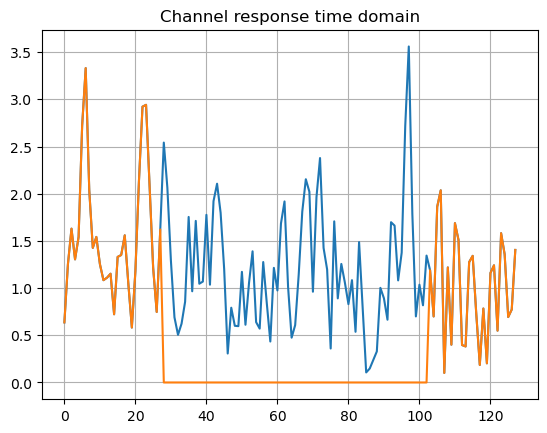

[0 1 1 0 0 1 1 0 0 0]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
SNRest=0.4784090705863584
BER=0.578125


In [14]:
samp_rate = sample_rate    # must be <=30.72 MHz if both channels are enabled
num_samps = len(repeated_frame)      # number of samples per buffer.  Can be different for Rx and Tx
rx_lo = int(center_freq)
rx_mode = "slow_attack"  # can be "manual" or "slow_attack"
rx_gain0 = 70
rx_gain1 = 70
tx_lo = rx_lo
tx_gain0 = -10
tx_gain1 = -10


data = np.random.randn(2,len(repeated_frame)) + 1j*np.random.randn(2,len(repeated_frame))
print(data[0].shape)
rx_sig = data[0] + data[1] #(1569,)
rx_len = len(rx_sig) # 1569

idx_max, corr_value = find_edges(rx_sig, frame_len, preamble_len, start_idx = 0) # (1),(1) 
frame_receive = rx_sig[idx_max : idx_max + frame_len] 

frame_receive = cfo(frame_receive, corr_value, preamble_len) if do_cfo_corr else frame_receive #(523,)
pilot_receive = frame_receive[N_fft + CP_len : 2*N_fft + CP_len] #(128,)

pilot_freq = np.fft.fft(pilot_receive, N_fft, 0, norm="ortho") #(128,)
rec_sym_pilot = baseband_freq_domian(pilot_freq, N_sc_use) #(64,1)

# apply CE
        #(64,1)               (64, 1)
h_ls = rec_sym_pilot[:, 0] / pilot_freq_[:,0] # (64,)
h_ls = channel_estimation(h_ls, CP_len, N_fft) if do_ce else h_ls

rec_data_sym = frame_receive[2 * (N_fft + CP_len) : 2 * (N_fft + CP_len) + N_fft] #(128,)
rec_data_sym_freq = np.fft.fft(rec_data_sym, N_fft, 0, norm="ortho") #(128,)
rec_sym_data = baseband_freq_domian(rec_data_sym_freq, BlockSize)# (64,1)
eq_data = rec_sym_data[:, 0] / h_ls #(64,)


bit_arr = demodulate(eq_data, N_sc_use) # (64)
ber = get_ber(data_stream, bit_arr, N_sc_use)
SNR_est = estimate_SNR(pilot_freq, rec_sym_pilot, N_sc_use)

print(data_stream[:10,0])
print(bit_arr[:10])
print(f'SNRest={SNR_est}')
print(f'BER={ber}')

In [15]:
import adi
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import scipy
import time
import pylab as pl
from IPython import display

import sionna as sn
import tensorflow as tf

sample_rate = 5e6
center_freq = 2.0e9

delta_t = 1 / sample_rate
delta_f = 30e3
frac_guard = 0.5

N_sc_av = int(sample_rate / delta_f)
N_fft = 2 ** (int(np.log2(N_sc_av)))
N_sc_use = int(N_fft * frac_guard)
guard_length = int(0.5 * N_fft)
CP_len = int(N_fft * 0.2)
num_bits_sym = 2

BlockSize = N_sc_use * num_bits_sym

do_cfo_corr = 1
do_ce = 1
dc_offset = 0


def create_preamble(N_fft, CP_len, N_repeat=2):
    preamble = 1 - 2 * np.random.randint(0, 2, size=(int(N_fft / 2), 1))
    preamble = np.complex64(preamble)
    preamble_full = np.tile(preamble, (N_repeat, 1))
    preamble_full_cp = np.concatenate((preamble_full[-CP_len:], preamble_full))
    return preamble_full_cp


def create_data(N_sc, N_fft, CP_len, mod_dict_data : dict, dc_offset=False, aditional_return=None, ):

    if mod_dict_data['num_bit'] == 1:
        data_stream = np.random.randint(0, 2, size=(N_sc, 1))
        data_stream_mod = 1 - 2 * data_stream
        mod_sym_pilot = np.complex64(data_stream_mod)
    else:
        binary_source = mod_dict_data['binary_source']
        mapper = mod_dict_data['mapper']

        bits = binary_source([1, N_sc * mod_dict_data['num_bit']])

        data_stream = bits.numpy().T

        mod_sym_pilot = mapper(bits)

        mod_sym_pilot = mod_sym_pilot.numpy().T




    tx_ofdm_sym = np.zeros((N_fft, 1), dtype=np.complex64)
    dc = int(dc_offset)
    tx_ofdm_sym[dc: N_sc // 2 + dc] = mod_sym_pilot[N_sc // 2:]
    tx_ofdm_sym[-N_sc // 2:] = mod_sym_pilot[0: N_sc // 2]

    time_ofdm_sym_pilot = np.fft.ifft(tx_ofdm_sym, axis=0, norm='ortho')
    time_ofdm_sym_cp_pilot = np.concatenate((time_ofdm_sym_pilot[-CP_len:], time_ofdm_sym_pilot))

    if aditional_return == 'mod_sym_pilot':
        return time_ofdm_sym_cp_pilot, mod_sym_pilot
    if aditional_return == 'data_stream':
        return time_ofdm_sym_cp_pilot, data_stream , mod_sym_pilot


#############################################################################
def find_edges(rx_sig, frame_len, preamble_len, CP_len, start_idx):
    corr_list = []
    for idx_search in range(start_idx, start_idx + frame_len):
        first_part = rx_sig[idx_search: idx_search + preamble_len]
        second_part = rx_sig[idx_search + preamble_len: idx_search + 2 * preamble_len]

        corr_now = np.dot(np.conj(first_part), second_part)
        corr_list.append(corr_now)

    corr_list_new = np.abs(np.array(corr_list))
    rel_idx = np.argmax(np.abs(corr_list_new), axis=0)
    idx_max = rel_idx + start_idx

    plt.figure(10)
    ax_corr = plt.gca()
    ax_corr.plot(range(len(corr_list)), np.array(corr_list_new), label='Orig')

    filter_cp = np.ones(CP_len) / np.sqrt(CP_len)
    corr_list_filt = np.convolve(filter_cp, corr_list_new, mode='same')

    rel_idx_filt = np.argmax(np.abs(corr_list_filt), axis=0)
    idx_max_filt = rel_idx_filt + start_idx
    idx_max_filt = idx_max_filt + int(CP_len/2)

    ax_corr.plot(range(len(corr_list)), corr_list_filt, label='filt')
    ax_corr.grid()
    plt.legend()

    #plt.show()

    if True:
        idx_max = idx_max_filt
        rel_idx = rel_idx_filt

    return idx_max, corr_list[rel_idx]


def cfo(frame_receive, corr_value, preamble_len):
    angle_cfo = np.angle(corr_value) / preamble_len
    cfo_comp_sig = np.exp(1j * (-1.0*angle_cfo * np.arange(0, frame_len)))
    frame_receive = frame_receive * cfo_comp_sig
    return frame_receive


def baseband_freq_domian(pilot_freq, N_sc_use):
    rec_sym_pilot = np.zeros((N_sc_use, 1), dtype=np.complex64)
    rec_sym_pilot[int(N_sc_use / 2):, 0] = pilot_freq[0 + dc_offset:int(N_sc_use / 2) + dc_offset]
    rec_sym_pilot[0:int(N_sc_use / 2), 0] = pilot_freq[-int(N_sc_use / 2):]

    return rec_sym_pilot


def channel_estimation(h_ls, CP_len, N_fft):
    h_time = np.fft.ifft(h_ls, N_fft, 0, norm='ortho')
    ce_len = len(h_ls)

    W_spead = int(CP_len / 2)
    W_sync_err = int(CP_len)
    W_max = W_spead + W_sync_err
    W_min = W_sync_err

    eta_denoise = np.zeros_like(h_time)
    eta_denoise[-W_min:] = 1.0
    eta_denoise[0:W_max] = 1.0

    h_time_denoise = h_time * eta_denoise

    h_hw = np.fft.fft(h_time_denoise, N_fft, 0, norm='ortho')
    h_ls = h_hw[0:ce_len]

    display.clear_output(wait=True)

    if True:
        plt.figure(100)
        plt.plot(np.arange(0, N_fft), np.abs(h_time))
        plt.plot(np.arange(0, N_fft), np.abs(h_time_denoise))
        plt.title('Channel response time domain')
        plt.grid();



    return h_ls


def estimate_SNR(pilot_freq, rec_sym_pilot, N_sc_use):
    noise_arr = pilot_freq[int(N_sc_use / 2): -int(N_sc_use / 2)]
    sigma0_freq = np.real(np.dot(np.conj(noise_arr), noise_arr)) / len(noise_arr)
    Es_freq = np.real(np.dot(np.conj(rec_sym_pilot[:, 0]), rec_sym_pilot[:, 0])) / len(rec_sym_pilot[:, 0])
    SNR_est = 10.0 * np.log10(Es_freq / sigma0_freq)
    return SNR_est


def demodulate(eq_data, N_sc_use, mod_dict):
    bit_arr = []

    if mod_dict_data['num_bit'] == 1:
        for idx in range(0, N_sc_use):

            if (np.real(eq_data[idx]) > 0):
                bit_curr = 0
            else:
                bit_curr = 1

            bit_arr.append(bit_curr)

        bit_arr = np.array(bit_arr)
        bit_arr = bit_arr[..., np.newaxis]
    else:
        eq_data_n = eq_data[..., np.newaxis]
        eq_data_t = tf.cast(eq_data_n.T, np.complex64)

        no = 1.0
        llr_tf = demapper([eq_data_t, no])
        llr = llr_tf.numpy()
        bit_arr_t = np.zeros_like(llr)
        bit_arr_t[llr > 0] = 1

        bit_arr = bit_arr_t.T

    return bit_arr


def get_ber(data_stream, bit_arr, N_sc_use):
    err_num = 0

    if False:
        for idx in range(0, N_sc_use):
            if (data_stream[idx, 0] != bit_arr[idx]):
                err_num = err_num + 1
        ber = 1.0 * err_num / N_sc_use

    ber = np.sum(data_stream != bit_arr) / len(data_stream)

    return ber


SNRest=14.387492838998938
mimo=1 BER=0.0078125


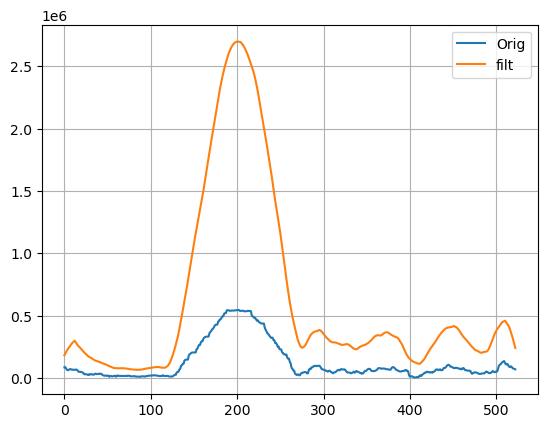

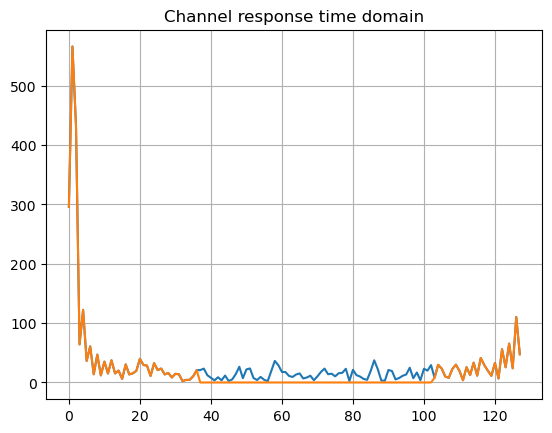

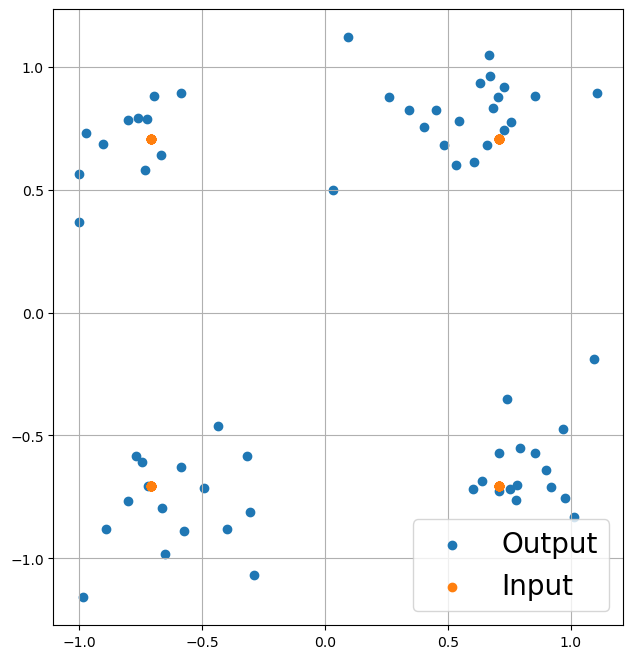

In [13]:
# Try Sionna
NUM_BITS_PER_SYMBOL = num_bits_sym

binary_source = sn.utils.BinarySource()
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable=True) # The constellation is set to be trainable

# Mapper and demapper
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("maxlog", constellation=constellation)

np.random.seed(123)
tf.random.set_seed(123)
preamble = create_preamble(N_fft, CP_len, 2)

mod_dict_pilot = dict()
mod_dict_pilot['num_bit'] = 1
pilot, pilot_freq_ = create_data(N_sc_use, N_fft, CP_len, mod_dict_pilot, aditional_return='mod_sym_pilot')

mod_dict_data = dict()
mod_dict_data['binary_source'] = binary_source
mod_dict_data['mapper'] = mapper
mod_dict_data['demapper'] = demapper
mod_dict_data['num_bit'] = num_bits_sym
data, data_stream, mod_sym_data = create_data(N_sc_use, N_fft, CP_len, mod_dict_data, aditional_return='data_stream')


guard = np.zeros((guard_length, 1), dtype=np.complex64)
frame = np.concatenate((preamble, pilot, data, guard))

repeated_frame = np.tile(frame, reps=(3, 1))

frame_len = len(frame)
preamble_len = N_fft // 2

#sdr = adi.Pluto(uri='ip:192.168.1.1')
#sdr = adi.ad9361(uri='ip:192.168.1.1')
sdr = adi.ad9361(uri='ip:192.168.1.1')
samp_rate = sample_rate  # must be <=30.72 MHz if both channels are enabled
num_samps = len(repeated_frame)  # number of samples per buffer.  Can be different for Rx and Tx
rx_lo = int(center_freq)
rx_mode = "slow_attack"  # can be "manual" or "slow_attack"
rx_gain0 = 70
rx_gain1 = 70
tx_lo = rx_lo
tx_gain0 = -10
tx_gain1 = -10


sdr.rx_enabled_channels = [0, 1]
sdr.sample_rate = int(samp_rate)
sdr.rx_lo = int(rx_lo)
sdr.gain_control_mode = rx_mode
sdr.rx_hardwaregain_chan0 = int(rx_gain0)
sdr.rx_hardwaregain_chan1 = int(rx_gain1)
sdr.rx_buffer_size = int(num_samps)

sdr.tx_enabled_channels = [0]
sdr.tx_lo = int(center_freq)
sdr.tx_rf_bandwidth = int(sample_rate)
sdr.tx_hardwaregain_chan0 = -50 # valid range is -90 to 0 dB
#sdr.tx_hardwaregain_chan1 = -50 # valid range is -90 to 0 dB
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(repeated_frame.ravel() * 10024.0) # start transmitting


do_save = False
for ii in range(10):
    data = sdr.rx()

    if do_save:
        path_save = f'C:\\dev\\git_tutor\\python_sdr\\tmp.mat'
        print(path_save)
        data = np.array(data)
        scipy.io.savemat(path_save, {'data': data})

    print(data[0].shape)

    for mimo in [0, 1]:

        if mimo == 0:
            rx_sig = data[0] + data[1]
        else:
            data = np.array(data)
            R = data @ data.conj().T
            U1, s1, V1 = np.linalg.svd(R)
            U_main = U1[:,0:1]
            rx_sig = U_main.conj().T @ data
            rx_sig = rx_sig[0]


        #rx_sig = data
        rx_len = len(rx_sig)

        idx_max, corr_value = find_edges(rx_sig, frame_len, preamble_len, CP_len, start_idx=0)
        frame_receive = rx_sig[idx_max: idx_max + frame_len]

        frame_receive = cfo(frame_receive, corr_value, preamble_len) if do_cfo_corr else frame_receive
        pilot_receive = frame_receive[N_fft + CP_len: 2 * N_fft + CP_len]

        pilot_freq = np.fft.fft(pilot_receive, N_fft, 0, norm="ortho")
        rec_sym_pilot = baseband_freq_domian(pilot_freq, N_sc_use)

        # apply CE
        h_ls = rec_sym_pilot[:, 0] / pilot_freq_[:, 0]
        h_ls = channel_estimation(h_ls, CP_len, N_fft) if do_ce else h_ls

        rec_data_sym = frame_receive[2 * (N_fft + CP_len): 2 * (N_fft + CP_len) + N_fft]
        rec_data_sym_freq = np.fft.fft(rec_data_sym, N_fft, 0, norm="ortho")
        rec_sym_data = baseband_freq_domian(rec_data_sym_freq, N_sc_use)
        eq_data = rec_sym_data[:, 0] / h_ls

        plt.figure(figsize=(8, 8))
        plt.axes().set_aspect(1.0)
        plt.grid(True)
        plt.scatter(np.real(eq_data), np.imag(eq_data), label='Output')
        plt.scatter(np.real(mod_sym_data), np.imag(mod_sym_data), label='Input')
        plt.legend(fontsize=20);

        bit_arr = demodulate(eq_data, N_sc_use, mod_dict_data)
        ber = get_ber(data_stream, bit_arr, N_sc_use)
        SNR_est = estimate_SNR(pilot_freq, rec_sym_pilot, N_sc_use)

        #print(data_stream[:10, 0])
        #print(bit_arr[:10])
        print(f'SNRest={SNR_est}')
        print(f'mimo={mimo} BER={ber}')
        plt.show()

    time.sleep(1)
    plt.show()

In [14]:
sdr.tx_destroy_buffer()